# Baseline EDA

Baseline exploratory data analysis aligned with the business brief (food price monitoring across shipping, energy, climate, FX, and local retail drivers) and the EDA plan.

In [11]:
# Ensure plotting deps are available in the current kernel
import sys, subprocess

for _pkg in ("matplotlib", "seaborn", "plotly", "kaleido"):
    try:
        __import__(_pkg)
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", _pkg])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
plt.style.use("seaborn-v0_8")

In [12]:
# Paths
data_candidates = [
    Path("..") / "data" / "cleaned.csv",  # running from notebooks/
    Path("data") / "cleaned.csv",         # running from project root
    Path("Final Project/Final Project Repo/data/cleaned.csv"),  # running from repo root
]
DATA_PATH = next((p for p in data_candidates if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("cleaned.csv not found; expected under data/ next to notebooks.")
DATA_PATH = DATA_PATH.resolve()

# Load
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

# Drop constant or all-null columns flagged in data-quality notes
null_cols = [c for c in ["ffpi_energy_consumption", "energy_imported"] if c in df.columns and df[c].isna().all()]
const_cols = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
cols_to_drop = [c for c in null_cols + const_cols if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Helper fields
regime_bins = pd.IntervalIndex.from_breaks(
    pd.to_datetime(["2017-12-31", "2019-12-31", "2022-12-31", "2025-12-31"])
)
df = df.assign(
    year=df["date"].dt.year,
    month=df["date"].dt.month,
    regime=pd.cut(
        df["date"],
        bins=regime_bins,
        labels=["2018-2019 (pre-COVID)", "2020-2022 (stress)", "2023-2025 (recent)"]
    ),
)

df.head()

,date,ffpi_food,ffpi_cereals,ffpi_veg_oils,ffpi_dairy,ffpi_meat,ffpi_sugar,bdi_price,gat_land_ocean,gat_land,gat_ocean,ffpi_usd_hkd_rate,ipi_food,rs_dairy_products,rs_fresh,wpm_fish,flag_iqr_outlier,year,month,regime
0,2018-01-01,96.70,95.20,98.25,106.00,95.30,87.20,"1,152.00",0.84,1.44,0.58,7.82,86.80,"1,957.00",961.00,36.30,False,"2,018.00",1.00,"(2017-12-31 00:00:00, 2019-12-31 00:00:00]"
1,2018-02-01,97.80,98.40,95.60,108.80,96.60,83.90,"1,192.00",0.89,1.62,0.57,7.83,87.10,"2,058.00",931.00,38.21,False,"2,018.00",2.00,"(2017-12-31 00:00:00, 2019-12-31 00:00:00]"
2,2018-03-01,98.80,101.80,95.36,111.30,96.60,80.90,"1,055.00",0.88,1.49,0.60,7.85,86.80,"1,867.00",925.00,35.25,False,"2,018.00",3.00,"(2017-12-31 00:00:00, 2019-12-31 00:00:00]"
3,2018-04-01,98.40,104.00,94.02,110.00,95.40,76.80,"1,341.00",0.91,1.46,0.66,7.85,86.80,"1,781.00",933.00,33.06,False,"2,018.00",4.00,"(2017-12-31 00:00:00, 2019-12-31 00:00:00]"
4,2018-05-01,98.50,105.50,92.15,111.40,94.90,76.40,"1,090.00",0.84,1.24,0.66,7.85,86.70,"1,992.00","1,006.00",35.00,False,"2,018.00",5.00,"(2017-12-31 00:00:00, 2019-12-31 00:00:00]"


In [ ]:
# Figure export helper (PNG)
export_base_candidates = [
    Path.cwd() / "docs" / "derived",
    Path.cwd().parent / "docs" / "derived",
    Path.cwd().parent.parent / "docs" / "derived",
    Path.cwd() / "Final Project Repo" / "docs" / "derived",
    Path.cwd() / "Final Project" / "Final Project Repo" / "docs" / "derived",
    Path.cwd().parent / "Final Project Repo" / "docs" / "derived",
]
export_dir = next((p for p in export_base_candidates if p.exists()), None)
if export_dir is None:
    export_dir = export_base_candidates[0]
export_dir.mkdir(parents=True, exist_ok=True)

fig_dir = export_dir / "02_baseline_eda_figures"
fig_dir.mkdir(exist_ok=True)


def save_fig(fig_obj, filename):
    path = fig_dir / filename
    try:
        if hasattr(fig_obj, "write_image"):
            fig_obj.write_image(path)
        elif hasattr(fig_obj, "savefig"):
            fig_obj.savefig(path, dpi=150, bbox_inches="tight")
        else:
            raise AttributeError("Object has no write_image or savefig")
        print(f"Saved figure to {path}")
    except Exception as exc:
        print(f"Could not save {filename}: {exc}")
    return path

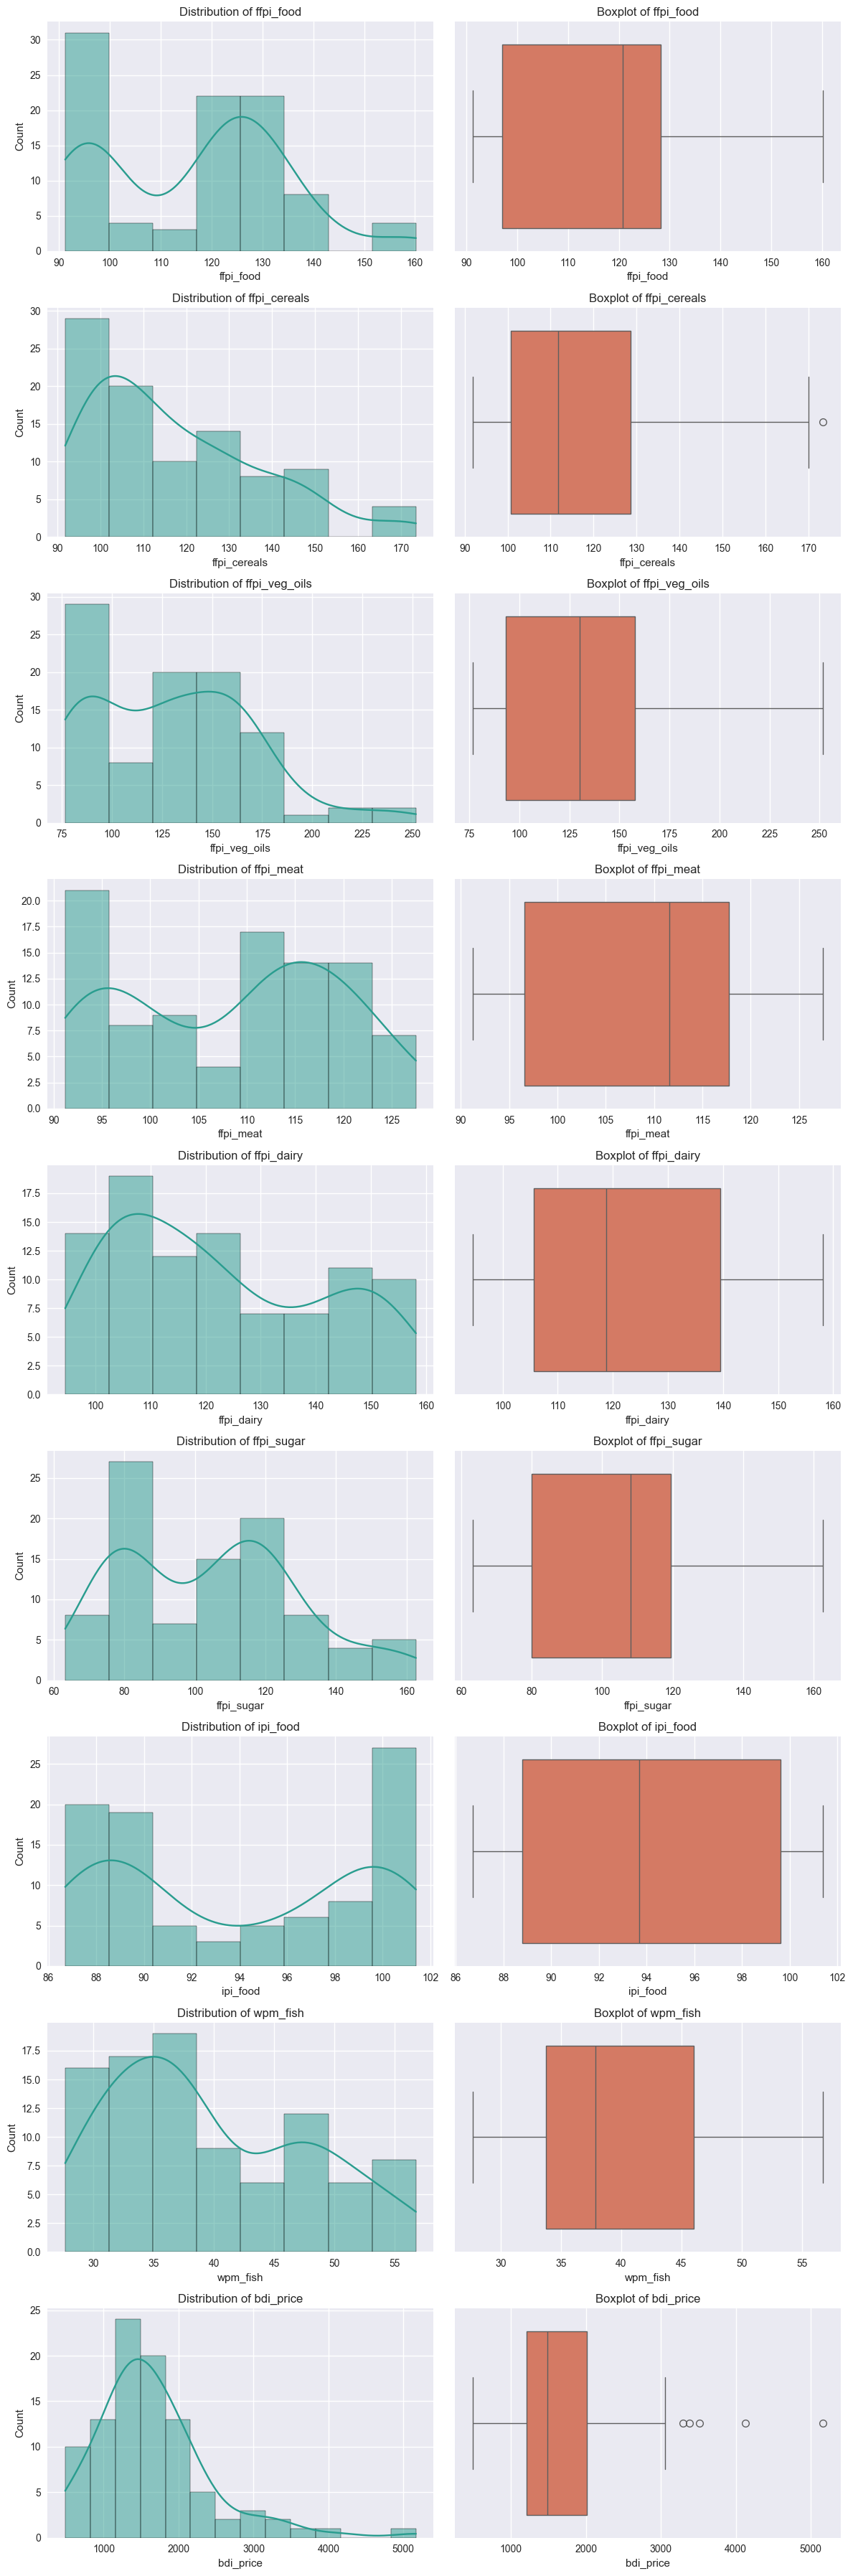

In [13]:
# Univariate distributions - key KPIs & drivers

kpi_cols = [
    "ffpi_food", "ffpi_cereals", "ffpi_veg_oils", "ffpi_meat", "ffpi_dairy", "ffpi_sugar",
    "ipi_food", "wpm_fish", "bdi_price"
]

fig, axes = plt.subplots(nrows=len(kpi_cols), ncols=2, figsize=(12, 4 * len(kpi_cols)))
for i, col in enumerate(kpi_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0], color="#2a9d8f")
    axes[i, 0].set_title(f"Distribution of {col}")
    sns.boxplot(data=df, x=col, ax=axes[i, 1], color="#e76f51")
    axes[i, 1].set_title(f"Boxplot of {col}")
plt.tight_layout()
save_fig(fig, "01_kpi_distributions.png")
plt.show()

In [14]:
# Time-series plots - overall KPIs

level_cols = ["ffpi_food", "ffpi_cereals", "ffpi_veg_oils", "ffpi_meat", "ffpi_dairy", "ffpi_sugar"]
fig = px.line(df, x="date", y=level_cols, title="FAO food indices over time")
fig.update_layout(legend_title_text="Index")
save_fig(fig, "02_ffpi_levels.png")
fig.show()

# Month-on-month change
for col in level_cols:
    df[f"mom_{col}"] = df[col].pct_change() * 100

mom_cols = [f"mom_{c}" for c in level_cols]
fig = px.line(df, x="date", y=mom_cols, title="MoM % change - FAO indices")
fig.update_yaxes(title_text="MoM %")
save_fig(fig, "03_ffpi_mom.png")
fig.show()

C:\Users\betoq\AppData\Local\Temp\ipykernel_18624\678454074.py:10: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\betoq\AppData\Local\Temp\ipykernel_18624\678454074.py:10: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\betoq\AppData\Local\Temp\ipykernel_18624\678454074.py:10: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\betoq\AppData\Local\Temp\ipykernel_18624\678454074.py:1

In [16]:
# Segment size plots - regime counts and missingness

regime_counts = df.groupby("regime").size().reset_index(name="months")
# Convert Interval objects to strings for JSON serialization
regime_counts["regime"] = regime_counts["regime"].astype(str)
fig = px.bar(regime_counts, x="regime", y="months", title="Months per regime (segment size)")
fig.update_layout(xaxis_title="Regime", yaxis_title="Number of months")
save_fig(fig, "04_regime_counts.png")
fig.show()

missing = df.isna().sum().reset_index(name="missing_rows").rename(columns={"index": "column"})
fig = px.bar(missing, x="column", y="missing_rows", title="Missing values per column")
fig.update_layout(xaxis_tickangle=45)
save_fig(fig, "05_missing_values.png")
fig.show()

C:\Users\betoq\AppData\Local\Temp\ipykernel_18624\1927244638.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [17]:
# Optional: time-series by driver family

# Shipping and import prices
fig = px.line(df, x="date", y=["bdi_price", "ipi_food"], title="Shipping & import price indicators")
save_fig(fig, "06_shipping_import.png")
fig.show()

# Climate anomalies
climate_cols = [c for c in ["gat_land_ocean", "gat_land", "gat_ocean"] if c in df.columns]
if climate_cols:
    fig = px.line(df, x="date", y=climate_cols, title="Global temperature anomalies")
    save_fig(fig, "07_climate_anomalies.png")
    fig.show()

# Local retail indicators
retail_cols = [c for c in ["rs_dairy_products", "rs_fresh", "wpm_fish"] if c in df.columns]
fig = px.line(df, x="date", y=retail_cols, title="Local retail/wholesale indicators")
save_fig(fig, "08_retail_indicators.png")
fig.show()

In [18]:
# Outlier overlay on FFPI

fig = px.line(df, x="date", y="ffpi_food", title="FFPI with IQR outlier flags")
outliers = df[df.get("flag_iqr_outlier", False)]
if not outliers.empty:
    fig.add_scatter(x=outliers["date"], y=outliers["ffpi_food"], mode="markers",
                    marker=dict(color="red", size=9), name="IQR outlier")
save_fig(fig, "09_ffpi_outliers.png")
fig.show()

In [ ]:
# Export notebook outputs to docs/derived for LLM consumption
from pathlib import Path
import nbformat
from nbconvert import HTMLExporter, MarkdownExporter

NB_NAME = "02_baseline_eda.ipynb"
nb_path_candidates = [
    Path(NB_NAME),
    Path("notebooks") / NB_NAME,
    Path.cwd() / NB_NAME,
    Path.cwd() / "notebooks" / NB_NAME,
]
nb_path_resolved = None
for candidate in nb_path_candidates:
    if candidate.exists():
        nb_path_resolved = candidate.resolve()
        break
if nb_path_resolved is None:
    raise FileNotFoundError(f"Could not find {NB_NAME} from {Path.cwd()}")

nb_node = nbformat.read(nb_path_resolved, as_version=4)
output_dir = nb_path_resolved.parent.parent / "docs" / "derived"
output_dir.mkdir(parents=True, exist_ok=True)

html_exporter = HTMLExporter(embed_images=True)
html_exporter.exclude_input_prompt = True
html_exporter.exclude_output_prompt = True
html_body, _ = html_exporter.from_notebook_node(nb_node)
(output_dir / "02_baseline_eda.html").write_text(html_body, encoding="utf-8")

md_exporter = MarkdownExporter()
md_exporter.exclude_input_prompt = True
md_exporter.exclude_output_prompt = True
md_body, resources = md_exporter.from_notebook_node(nb_node)
(output_dir / "02_baseline_eda.md").write_text(md_body, encoding="utf-8")

if resources.get("outputs"):
    files_dir = output_dir / "02_baseline_eda_files"
    files_dir.mkdir(exist_ok=True)
    for filename, data in resources["outputs"].items():
        (files_dir / filename).write_bytes(data)

print(f"Wrote HTML and Markdown exports to {output_dir}")